<a href="https://colab.research.google.com/github/deepskies/proj-clusters-sz-sbi/blob/sim_dev/mass_sampling_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the code to create sample of mass of galaxy clusters based on the halo mass function and redshift distribution. 

original document: https://colab.research.google.com/drive/1pK9xwy4FDU39mkhVPtj0yXC1lBJZll6U

Packages:
1. colossus, https://bdiemer.bitbucket.io/colossus/lss_mass_function.html#lss.mass_function.massFunction
2. scipy interpolation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
3. scipy integration: https://docs.scipy.org/doc/scipy/tutorial/integrate.html
4. emcee for MCMC: https://emcee.readthedocs.io/en/stable/user/sampler/
5. redshift distribution (used skewed gaussian to imitate): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html#scipy.stats.skewnorm

Hanzhi Tan


In [ ]:
# all packages
! pip install colossus

from colossus.cosmology import cosmology
from colossus.lss import mass_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import preprocessing
from scipy import interpolate
from scipy import integrate

import math
!pip install emcee
import emcee
import random

import time

! pip install h5py
import h5py
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 11.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#extract power function
def extract_power(mass_arr, mfunc):
  """
  Function to extract power of galaxy cluster mass array, and normalize mfunc, prepare for 

  parameters:
  -----------
  mass_arr: 1d numpy array of cluster mass in 10^n M⊙ unit
  mfunc: 1d numpy array of halo numbr density in dN/dlog(M)(Mpc/ℎ)^(−3) unit

  mass_arr_p: 1d numpy array of mass of power = n
  mfunc_n: 1d numpy array of halo number density * 10^5 #mfunc unit doesnt work in this way, will be changed later 
  """
  mass_arr_p = np.log10(mass_arr)
  mfunc_n = mfunc*(10**5)
  return mass_arr_p, mfunc 

In [ ]:
#the likelihood function
def lnpo(mass, min, max, test_fun):
  """
  likelihood function used by MCMC

  parameters:
  -----------
  mass: a float or a 1d numpy array of cluster mass in 10^n M⊙ unit
  """
  if (mass < min) or (mass > max):
    return -np.inf
  return math.log(test_fun(mass)) #log likelihood is required by emcee

In [ ]:
redshift = 0.0
sample_num = 10
filename = "rs_" + str(redshift) + "_sn_" + str(sample_num) + "_mcmc_save.h5"
print(filename)

rs_0.0_sn_10_mcmc_save.h5


In [ ]:
def interpolate_MCMC(mass_array_p, mfunc_n, mass_range, sample_num, redshift):
  """
  interpolate and normalize mfunc_n, use the result as a likelihood function and perform MCMC method to get sample.

  parameters:
  -----------
  mass_arr_p: 1d numpy array of cluster mass power (for example, 10^14 M⊙ represented as 14 in arr)
  mfunc_n: 1d numpy array of halo number density * 10^5
  mass_range: a tuple of cluster masses, lower limit and upper limit for sampling
  sample_num: an integer of number of sample

  sample_chain.flatten(): an 1d numpy array of mass sampling, same unit as mass_arr_p
  """
  min, max = mass_range
  print(min, max)
  #interpolate
  from scipy import interpolate
  interpolate_mfunc = interpolate.interp1d(mass_array_p, mfunc_n)
  test_arr = np.linspace(min, max, 5000)
  f_test = interpolate_mfunc(test_arr)
  #normalize to likelihood function by divided by integration, looking for better method
  from scipy import integrate
  val, err = integrate.quad(interpolate_mfunc, min, max)
  test_fun = interpolate.interp1d(test_arr, (f_test/val))
  #plt.plot(test_arr, f_test/val, marker = 'o')
  #nval, nerr = integrate.quad(test_fun, min, max), 5000 test points will lead to error < 10^-4

  #create random walkers
  import emcee
  import random
  randomlist = []
  for i in range(20):
    n = random.uniform(min, max)
    randomlist.append(n)
  random_arr = np.array(randomlist)

  #backend setup
  ndim, nwalkers = 1, 20
  # name = "rs_" + str(redshift) + "_sn_" + str(sample_num)
  # file_name = "mcmc_save.h5"
  # backend = emcee.backends.HDFBackend(filename, name = name)
  # backend.reset(nwalkers, ndim)

  #run MCMC
  import time
  processed_sample_num = sample_num // (ndim * nwalkers)
  p0 = random_arr.reshape((nwalkers, ndim))
  the_random = random.uniform(1.0, 100.0)
  locals()["sample" + str(the_random)] = emcee.EnsembleSampler(nwalkers, ndim, lnpo, args = [min, max, test_fun])
  t0=time.time()
  pos, prob, state = locals()["sample" + str(the_random)].run_mcmc(p0, 25000) #burn-in sequence
  locals()["sample" + str(the_random)].reset()
  t1=time.time()
  print( ' Done with burn-in: ', t1-t0)
  locals()["sample" + str(the_random)].run_mcmc(pos, processed_sample_num)
  t2=time.time()
  print( ' Done with MCMC: ', t2-t1)

  mass_chain = locals()["sample" + str(the_random)].chain
  locals()["sample" + str(the_random)].reset() #prevent storing error
  return test_fun, mass_chain.flatten()


In [ ]:
def mass_sampling(mass_range, redshift = 0.0, mdef = '200c', model = 'bocquet16', sample_num = 100000):
  """
  the function to give back a sample of mass distribution based on halo mass function 
     
  Parameters:
  ----------- 
  mass_range: a tuple of cluster masses, lower limit and upper limit for sampling
  redshift: a float, 0.0 by deault
  sample_num: an integer of number of sample, 100000 by default
  mdef: The mass definition in which the halo mass M is given
  model: the halo mass function model used by colossus 

  mass_chain: a numpy array of length = sample_num.
  test_func: the likelihood function
  """
  from colossus.cosmology import cosmology
  from colossus.lss import mass_function
  import numpy as np
  min, max = mass_range
  mass_arr = np.logspace(min, max, num = 200, base = 10)
  cosmology.setCosmology('WMAP9')
  mfunc = mass_function.massFunction(mass_arr, redshift, mdef = mdef, model = model, q_out = 'dndlnM')
  mass_arr_p, mfunc_n = extract_power(mass_arr, mfunc)
  test_func, prim_mass_sample = interpolate_MCMC(mass_arr_p, mfunc_n, mass_range, sample_num, redshift)
  return test_func, prim_mass_sample

In [ ]:
def unit_switch(prim_mass_sample):
  """
  switch from n to 10^n

  Parameters:
  ----------- 
  prim_mass_sample: a priliminary numpy array

  mass_sample: a numpy array of cluter mass after unit transformation
  """
  mass_sample = np.power(10, prim_mass_sample)
  return mass_sample


test

In [ ]:
#code to demonstrate the final result
def plot_pdf(xr, title, func=None, args=None, label='ITS method', 
             ylog=True,
             bins = 50, xlims=[], ylims=[], figsize=3):
    """
    by Andrey Kravtsov
    wrapper convenience function for plotting  histogram of a sequence of floats xr
    and comparing it to a theoretical distribution given by func
    
    Parameters:
    -----------
    xr: 1d numpy array of floats, values in the sequence to plot
    func: Python function object handle
    args: list of arguments to the function
    other parameters are used for plotting
    """
    plt.figure(figsize=(figsize,figsize))
    if ylog: plt.yscale('log') # plot y-values on a logarithmic scale
    if ylims: plt.ylim(ylims) # set axis limits 
    if xlims: plt.xlim(xlims)
    # compute histogram values 
    hist, bins, patches = plt.hist(xr, density=True, bins=bins, label=label)
    binc = 0.5*(bins[1:] + bins[:-1]) # compute bin centers
    plt.plot(binc, func(binc), lw=5, c='orangered', label='target pdf')
    plt.title(title, fontsize=3*figsize)
    plt.ylabel(r'$likelihood$') # label axis 
    plt.xlabel(r'$mass$')
    plt.legend(loc='best', frameon=False, fontsize=3*figsize)
    plt.show()

In [ ]:
index = [0, 1]
mass_range = [14.0, 16.0]
mass_chain = []
for i in index:
  test_func, chain = mass_sampling(mass_range, redshift = i, sample_num = 1000)
  mass_chain.append(chain.tolist())


14.0 16.0
 Done with burn-in:  30.18522810935974
 Done with MCMC:  0.046474456787109375
Deleted outdated persistence file, no further action needed.
14.0 16.0
 Done with burn-in:  23.966240882873535
 Done with MCMC:  0.0475773811340332


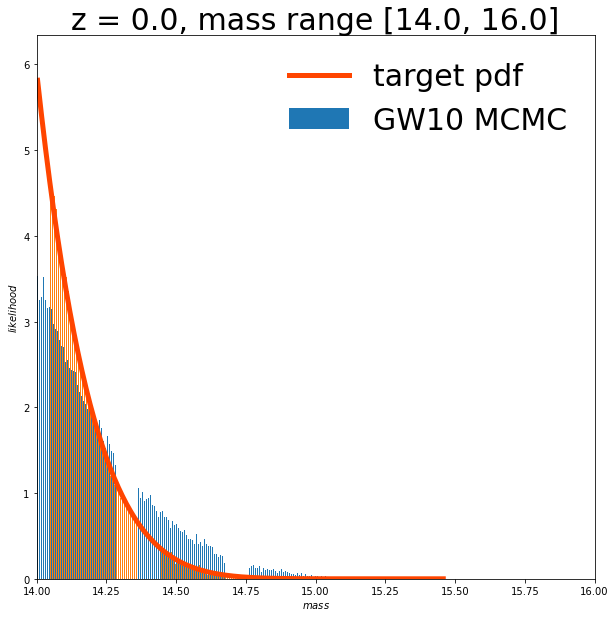

In [ ]:
plot_pdf(mass_chain, "z = 0.0, mass range [14.0, 16.0]", func=test_func, xlims=mass_range, ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
14.0 16.0
 Done with burn-in:  23.29650378227234
 Done with MCMC:  4.408108949661255


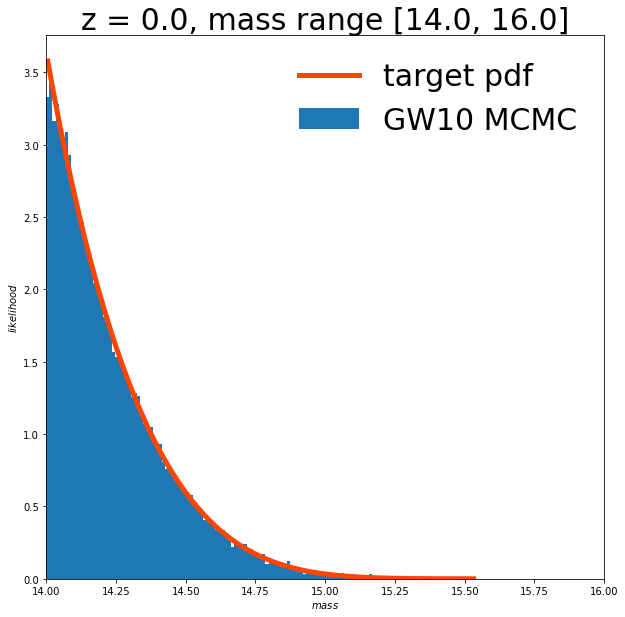

In [ ]:
#simplest case
mass_range = [14.0, 16.0]
test_func, mass_chain = mass_sampling(mass_range)
plot_pdf(mass_chain, "z = 0.0, mass range [14.0, 16.0]", func=test_func, xlims=mass_range, ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
14.0 16.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


 Done with burn-in:  34.27719712257385
 Done with MCMC:  5.373320579528809


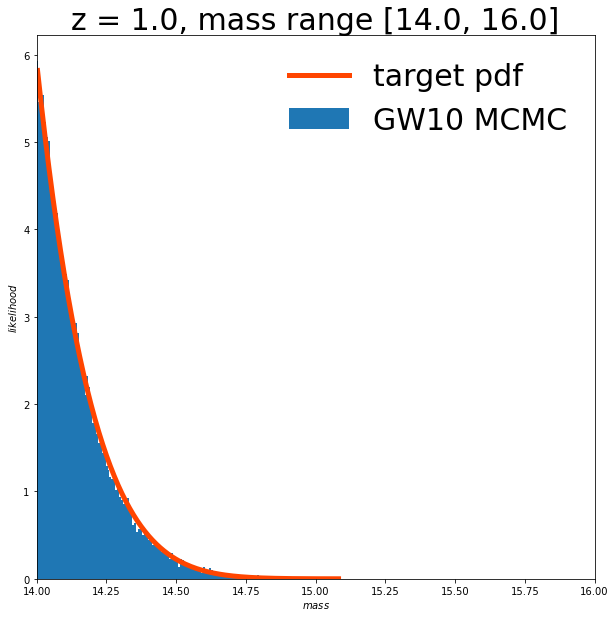

In [ ]:
test_func, mass_chain = mass_sampling(mass_range, redshift = 1.0)
plot_pdf(mass_chain, "z = 1.0, mass range [14.0, 16.0]", func=test_func, xlims=mass_range, ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
0.0 16.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


 Done with burn-in:  23.769664525985718
 Done with MCMC:  4.693682432174683


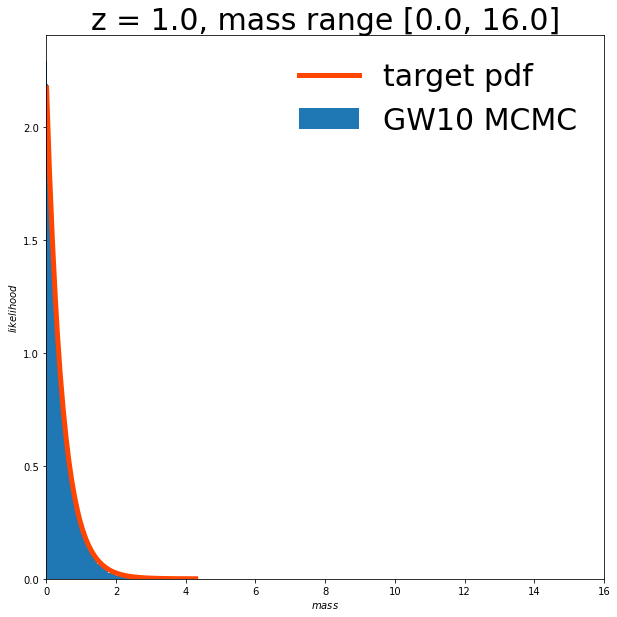

In [ ]:
test_func, mass_chain = mass_sampling([0.0, 16.0], redshift = 1.0)
plot_pdf(mass_chain, "z = 1.0, mass range [0.0, 16.0]", func=test_func, xlims=[0.0, 16.0], ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
0.0 14.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


 Done with burn-in:  23.520561695098877
 Done with MCMC:  4.62984037399292


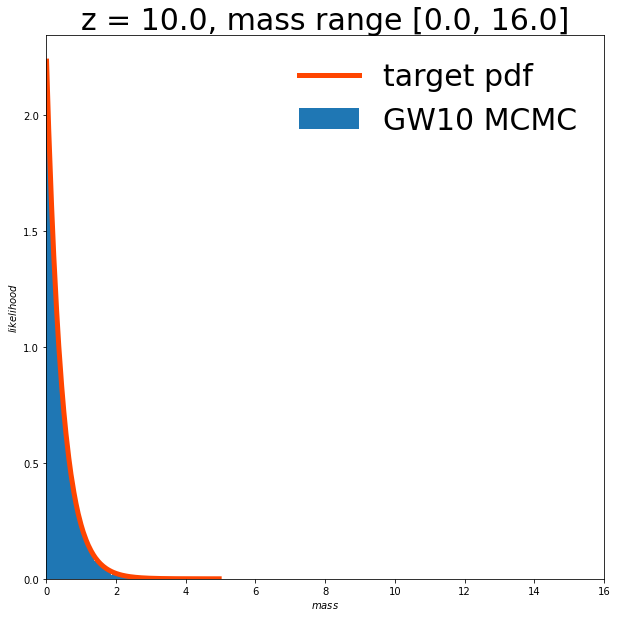

In [ ]:
test_func, mass_chain = mass_sampling([0.0, 14.0], redshift = 10.0)
plot_pdf(mass_chain, "z = 10.0, mass range [0.0, 16.0]", func=test_func, xlims=[0.0, 16.0], ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
14 16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


 Done with burn-in:  26.466422080993652
 Done with MCMC:  4.9060986042022705


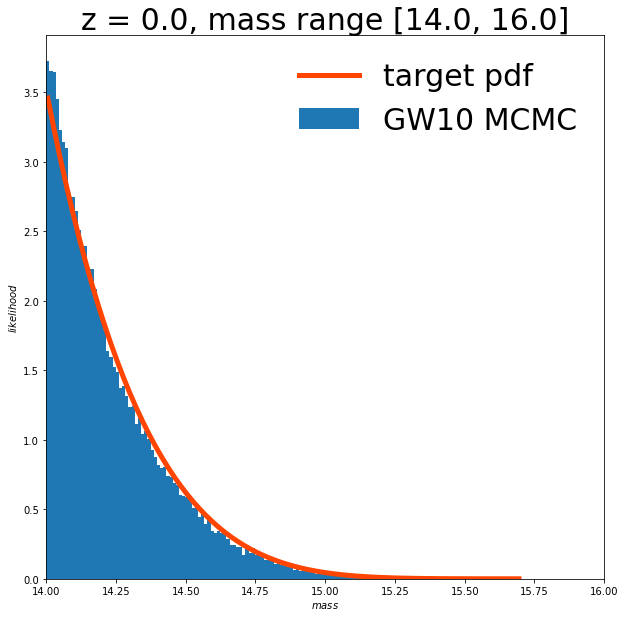

In [ ]:
#test model, mdef, sample_num
test_func, mass_chain = mass_sampling([14, 16], redshift = 0.0, mdef = 'vir', model = 'seppi20', sample_num = 100000)
plot_pdf(mass_chain, "z = 0.0, mass range [14.0, 16.0]", func=test_func, xlims=[14.0, 16.0], ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

multiple redshift sample
, shape of redshift reference: 
1. https://arxiv.org/pdf/2101.08373.pdf
2. https://pole.uchicago.edu/public/data/sptsz-clusters/


code reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html#scipy.stats.skewnorm

[3.54022253 5.81282068 2.42017138 2.12025557 3.12913104 2.92561706
 2.78770369 3.38312275 4.28274762 3.39611452]


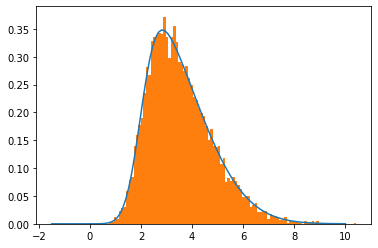

In [ ]:
# redshift distribution imitation
from scipy.stats import skewnorm
a = 4
x = np.linspace(-1.5, 10, 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, skewnorm.pdf(x, a, loc = 2, scale = 2)) #loc = mean, scale = standard deviation
sample = skewnorm.rvs(a, loc = 2, scale = 2, size = 10000)
ax.hist(sample, bins = 100, density = True)
print(sample[:10])
#https://astro.ucla.edu/~wright/cosmo_02.htm#DA ->astrophysics calculator
#https://arxiv.org/pdf/2101.08374.pdf ->changing aperture

Text(0, 0.5, 'num')

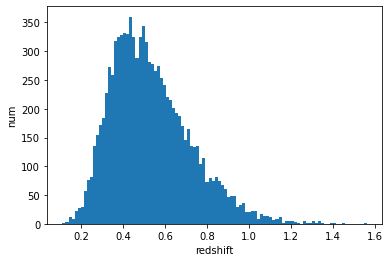

In [ ]:
#adapt to correct redshift
plt.hist(sample/6.6666, bins = 100)
plt.xlabel("redshift")
plt.ylabel("num")

In [ ]:
rs_sample = sample/6.6666
chop = np.linspace(0, 1.5, 100) #
print(chop)
print(rs_sample[:10])

[0.         0.01515152 0.03030303 0.04545455 0.06060606 0.07575758
 0.09090909 0.10606061 0.12121212 0.13636364 0.15151515 0.16666667
 0.18181818 0.1969697  0.21212121 0.22727273 0.24242424 0.25757576
 0.27272727 0.28787879 0.3030303  0.31818182 0.33333333 0.34848485
 0.36363636 0.37878788 0.39393939 0.40909091 0.42424242 0.43939394
 0.45454545 0.46969697 0.48484848 0.5        0.51515152 0.53030303
 0.54545455 0.56060606 0.57575758 0.59090909 0.60606061 0.62121212
 0.63636364 0.65151515 0.66666667 0.68181818 0.6969697  0.71212121
 0.72727273 0.74242424 0.75757576 0.77272727 0.78787879 0.8030303
 0.81818182 0.83333333 0.84848485 0.86363636 0.87878788 0.89393939
 0.90909091 0.92424242 0.93939394 0.95454545 0.96969697 0.98484848
 1.         1.01515152 1.03030303 1.04545455 1.06060606 1.07575758
 1.09090909 1.10606061 1.12121212 1.13636364 1.15151515 1.16666667
 1.18181818 1.1969697  1.21212121 1.22727273 1.24242424 1.25757576
 1.27272727 1.28787879 1.3030303  1.31818182 1.33333333 1.34848

In [ ]:
a = rs_sample < 4
b = rs_sample > 1
tot = a & b
print(np.count_nonzero(tot))

193


In [ ]:

num_per_redshift = []
for i, redshift in enumerate(chop):
    condition1 = redshift <= rs_sample
    if redshift != 1.5:
        condition2 = rs_sample < chop[i + 1]
    else:
        condition2 = rs_sample < float('inf')

    condition = condition1 & condition2
    num = np.count_nonzero(condition)
    num_per_redshift.append(num)
print(len(num_per_redshift))
num_per_redshift = np.array(num_per_redshift)

100


[  0   0   0   0   0   0   0   2   1  11   7  21  32  31  60  79  90 148
 167 172 207 264 264 316 312 362 347 332 364 348 327 313 358 326 304 291
 279 284 273 255 225 223 204 192 198 164 163 152 142 144 115 126  94  76
  68  94  75  70  65  51  53  47  30  35  33  21  27  22  15  12  18  17
  12   4  12  13   1   4   4   5   3   1   0   4   2   1   4   2   4   2
   0   0   1   1   0   0   1   0   0   1]


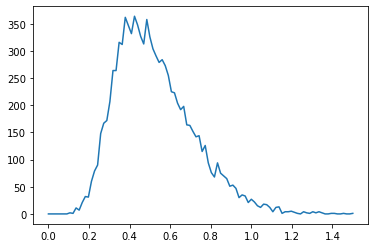

In [ ]:
plt.plot(chop, num_per_redshift)
print(num_per_redshift[:100])

In [ ]:
class masses:
  def __init__(self, function, redshift, arr):
      self.fxn = function
      self.redshift = redshift
      self.arr = arr

In [ ]:
# redshift = 0
# sample_num = 100
# test_func, mass_chain = mass_sampling([14.0, 16.0], redshift = redshift, sample_num = sample_num)

In [ ]:
final_mass_list = []
for redshift in chop:
  print(f"starting running with redshift: {redshift}")
  test_func, chain = mass_sampling(mass_range, redshift = redshift, sample_num = 10)
  final_mass_list.append(chain.tolist())

starting running with redshift: 0.0
Deleted outdated persistence file, no further action needed.
14.0 16.0
 Done with burn-in:  22.673181772232056
 Done with MCMC:  0.00214385986328125


AttributeError: ignored

In [ ]:
final_mass_list = []
mass_range = [14.0, 16.0]
for i in range(100):
    sample_n = num_per_redshift[i] * 10
    if (sample_n//20) == 0:
        continue
    redshift = chop[i]
    print(f"starting running with redshift: {redshift}, sample_num : {sample_n}")
    test_func, chain = mass_sampling(mass_range, redshift = chop[i], sample_num = sample_n)
    final_mass_list.append(masses(test_func, redshift, chain))

starting running with redshift: 0.10606060606060606, sample_num : 20
Deleted outdated persistence file, no further action needed.
14.0 16.0
 Done with burn-in:  22.79031538963318
 Done with MCMC:  0.0032117366790771484
starting running with redshift: 0.13636363636363635, sample_num : 110
Deleted outdated persistence file, no further action needed.
14.0 16.0
 Done with burn-in:  23.62138319015503
 Done with MCMC:  0.008518218994140625
starting running with redshift: 0.15151515151515152, sample_num : 70
Deleted outdated persistence file, no further action needed.
14.0 16.0
 Done with burn-in:  22.77565836906433
 Done with MCMC:  0.004817485809326172
starting running with redshift: 0.16666666666666669, sample_num : 210
Deleted outdated persistence file, no further action needed.
14.0 16.0
 Done with burn-in:  22.476534366607666
 Done with MCMC:  0.01395559310913086
starting running with redshift: 0.18181818181818182, sample_num : 320
Deleted outdated persistence file, no further action ne

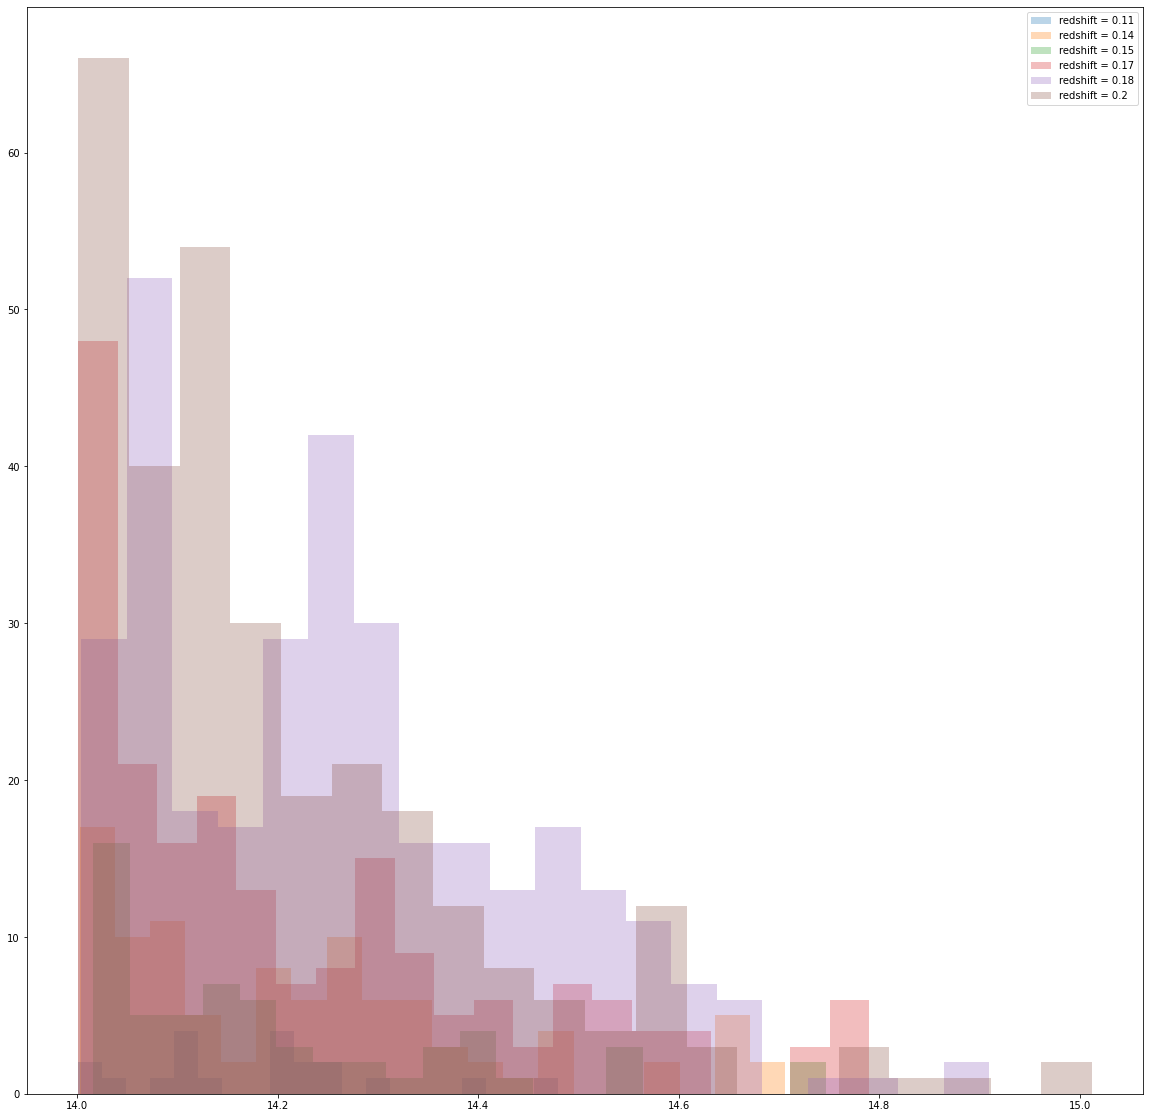

In [ ]:
plt.figure(figsize=(20, 20))
for a in final_mass_list:
    if a.redshift < 0.2:
      redshift = str(round(a.redshift, 2))
      plt.hist(a.arr, bins = 20, alpha = 0.3, label = "redshift = " + redshift)
      plt.legend(loc='upper right')

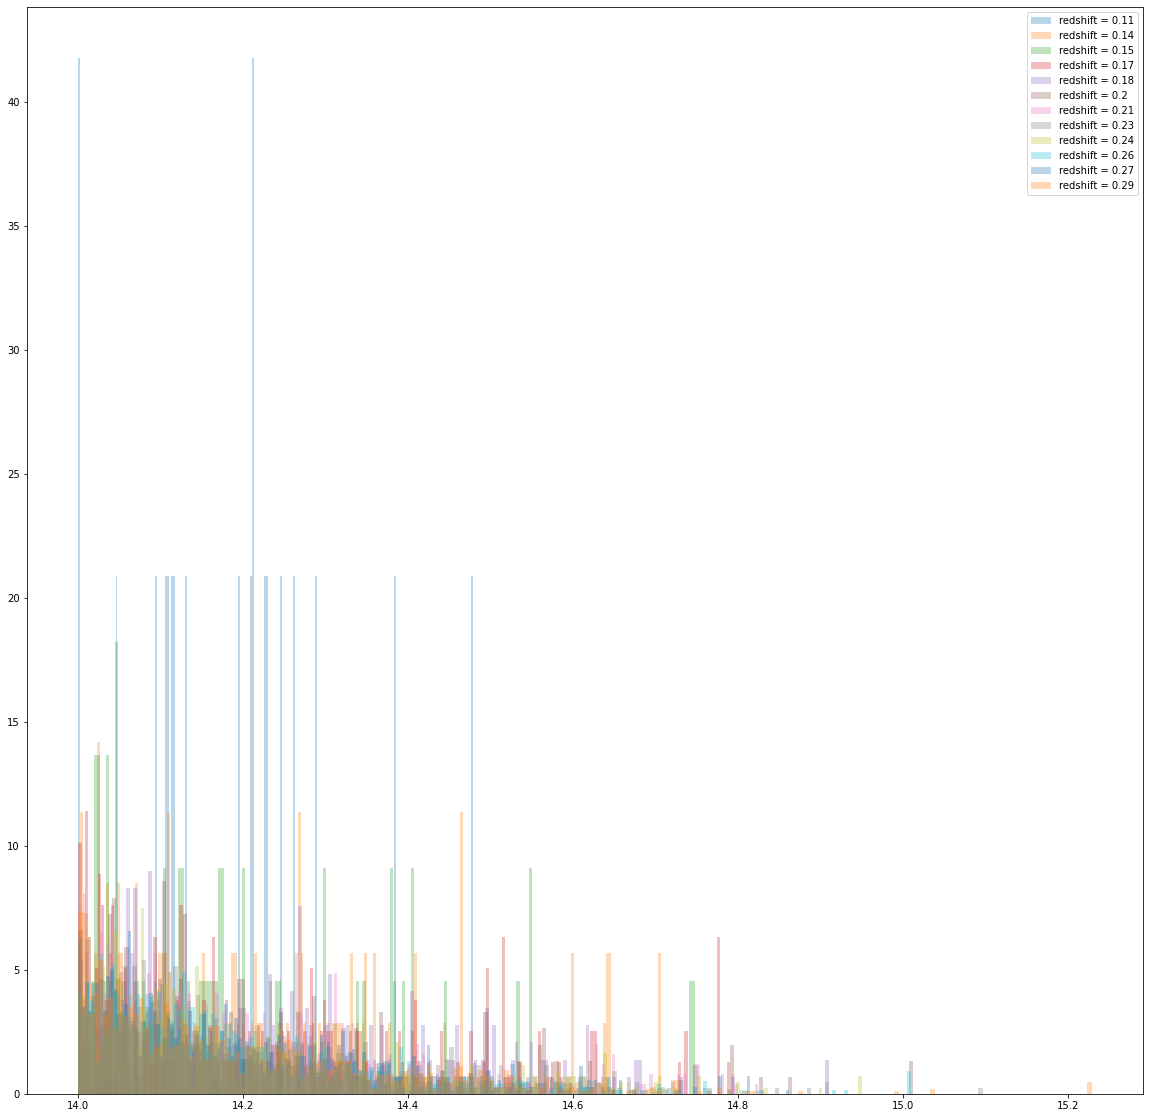

In [ ]:
plt.figure(figsize=(20, 20))
for a in final_mass_list:
    if 0.1 < a.redshift < 0.3:
      redshift = str(round(a.redshift, 2))
      plt.hist(a.arr, bins = 200, density=True, alpha = 0.3, label = "redshift = " + redshift)
      plt.legend(loc='upper right')

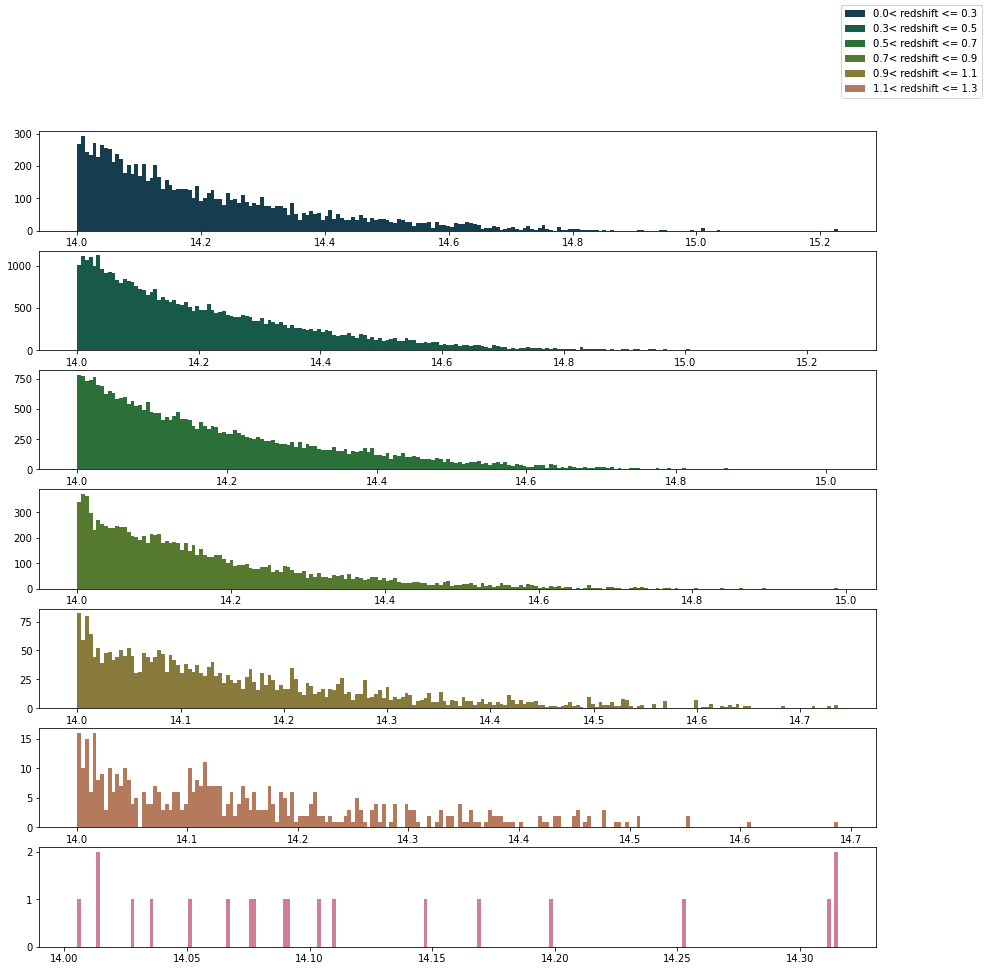

In [ ]:
import matplotlib.cm as cm
fig, axis = plt.subplots(7, figsize=(15, 15))
#0.0-0.3, 0.3-0.5, 0.5-0.7, 0.7-0.9, 0.9-1.1, 1.1-1.3, 1.3-
redshift_arr = [0.0, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
rs_idx = 0
colors = cm.cubehelix(np.linspace(.2, .6, 7))
fin_arr = final_mass_list[0].arr


for i, a in enumerate(final_mass_list):
    if i == (len(final_mass_list) - 1):
        axis[rs_idx].hist(a.arr, bins = 200, alpha = 1, label = (str(round(redshift_arr[rs_idx], 2)) + "< redshift"), color = colors[rs_idx])
    elif a.redshift < redshift_arr[rs_idx + 1]:
        fin_arr = np.concatenate((fin_arr, final_mass_list[i + 1].arr))
    else:
        axis[rs_idx].hist(fin_arr, bins = 200, alpha = 1, label = str(round(redshift_arr[rs_idx], 2)) + "< redshift <= " + str(round(redshift_arr[rs_idx + 1], 2)), color = colors[rs_idx])
        fig.legend(loc='upper right')
        rs_idx += 1
        fin_arr = final_mass_list[i + 1].arr
    # axis.xlabel("mass, 10^x")
    # axis.ylabel("num")